In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import plot
from pycodamath import extra
import scipy.optimize as optimization

#### 1. Data Loading

In [2]:
import pandas as pd
import re

# Load data
data = pd.read_csv('../data/2-meteorites.csv', sep=',')
data.rename(columns={'Unnamed: 0': 'Location'}, inplace=True)

# Strip leading and trailing spaces from all column names
data.columns = data.columns.str.strip()

# Extract the part inside parentheses into 'Type'
data['Type'] = data['Location'].str.extract(r'\((.*?)\)')

# Remove the parentheses and content from 'Location'
data['Location'] = data['Location'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# Reorder columns: Location, Type, then the rest
cols = ['Location', 'Type'] + [col for col in data.columns if col not in ['Location', 'Type']]
data = data[cols]

data.iloc[:, 2:] = data.iloc[:, 2:].coda.closure(100)

# Check result
print(data.head())
print(data.shape)


    Location Type       SiO2     Al2O3        FeO       MnO        MgO  \
0    Allende   cc  37.915374  3.622065  30.073106  0.199380  27.270713   
1       Bali   cc  37.892729  3.545781  29.746409  0.213196  27.535907   
2  Efremovka   cc  39.220393  3.852309  19.661637  0.217193  28.246456   
3   Coolidge   cc  42.960559  4.131303   9.061408  0.299551  31.190714   
4    Ankober   hc  39.378411  2.584382  14.537150  0.356467  25.465077   

          Fe        Ni        Co         C  
0   0.188303  0.398759  0.011077  0.321223  
1   0.168312  0.246858  0.011221  0.639587  
2   6.298583  1.566072  0.068587  0.868770  
3  10.334498  1.684973  0.099850  0.237144  
4  15.550852  1.904868  0.111396  0.111396  
(12, 11)


#### 2. Visulisation

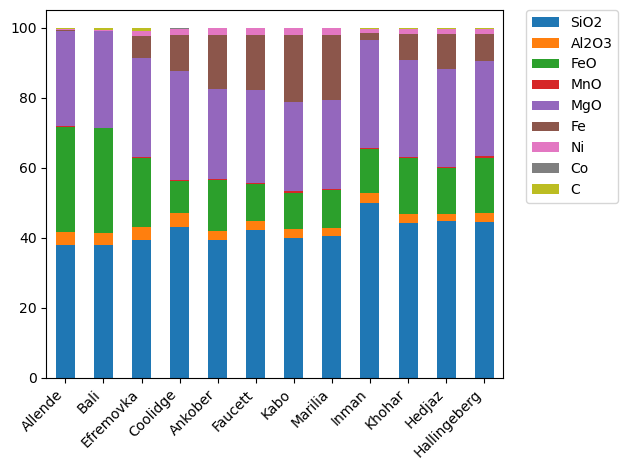

In [3]:
import matplotlib.pyplot as plt

# Apply coda closure
data.iloc[:, 2:] = data.iloc[:, 2:].coda.closure(100)

# Plot
ax = data.plot.bar(stacked=True)

# Set x-axis tick labels
ax.set_xticks(range(len(data.iloc[:, 0])))
ax.set_xticklabels(data.iloc[:, 0], rotation=45, ha='right')  # Rotate if needed

# Move legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.savefig('../handin/figures/stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()


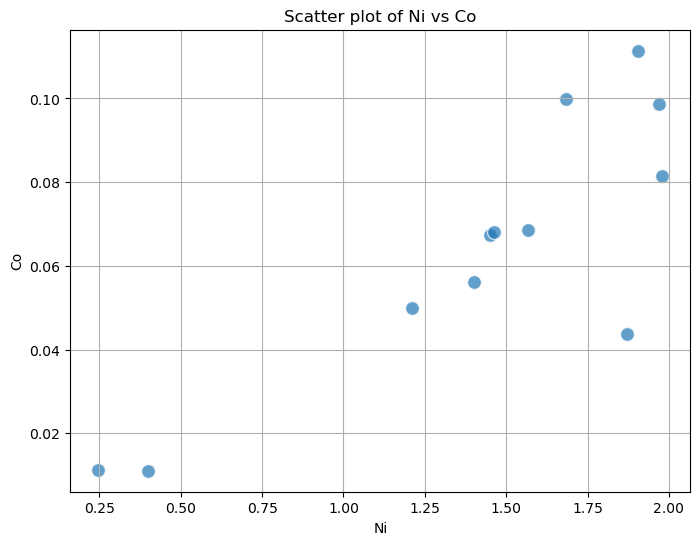

In [4]:
#PLot Ni and Co in a scatter plot
# Create a scatter plot of Ni vs Co
plt.figure(figsize=(8, 6))
plt.scatter(data['Ni'], data['Co'], alpha=0.7, edgecolors='w', s=100)
plt.title('Scatter plot of Ni vs Co')
plt.xlabel('Ni')
plt.ylabel('Co')
plt.grid(True)
plt.show()


we see that there is an obvious difference in the compositions of the meteorise fromt the 12 different origins
How obivius the cc/hc/ic groups overall effect on the compositions is not obious from this plot

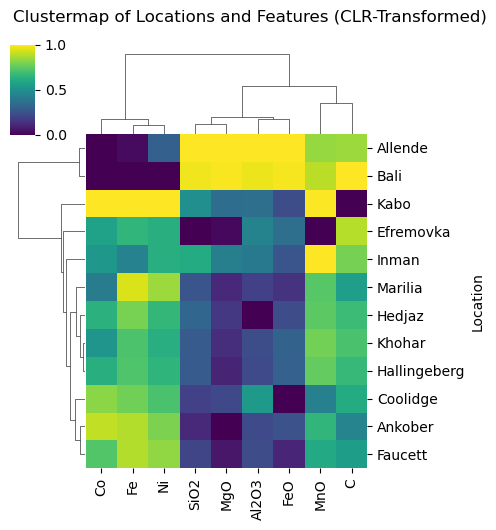

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


dataclr = pd.concat([data.iloc[:, :1], data.iloc[:, 2:].coda.clr()], axis=1)

# Assume clr_data has the 'Locations' column as the first column and features after
clr_features = dataclr.drop(columns=['Location'])
locations = dataclr['Location']

# Set 'Locations' as the row index so labels show on the heatmap
clr_features.index = locations

# Create clustermap
sns.clustermap(clr_features, cmap='viridis', metric='euclidean', method='ward', 
               figsize=(5, 5), standard_scale=1)

plt.suptitle('Clustermap of Locations and Features (CLR-Transformed)', y=1.05)

plt.savefig('../handin/figures/clustermap.png', dpi=300, bbox_inches='tight')
plt.show()


#### 2.1 PCA

We have to first need to calculate the geometric means for each row of the closed data
$$
\mathbf{g} = (g_1, g_2, \dots, g_D), \quad \text{where} \quad g_j = \left( \prod_{i=1}^n x_{ij} \right)^{1/n}
$$

Variantion matrix

$$
t_{jk} = \frac{1}{n} \sum_{i=1}^n \left( \ln \frac{x_{ij}}{x_{ik}} - m_{jk} \right)^2
$$
$$
m_{jk} = \frac{1}{n} \sum_{i=1}^n \ln \frac{x_{ij}}{x_{ik}}
$$
Total varaince: 
$$
\text{TotVar}[T] = \frac{1}{2D} \sum_{i,j=1}^D t_{ij}
$$

Pertube the data by inverse of gm which
$$ data ⊕ gm$$
$$ data * \frac{1}{gm}$$
This equvilant to centereing the non compositional data.

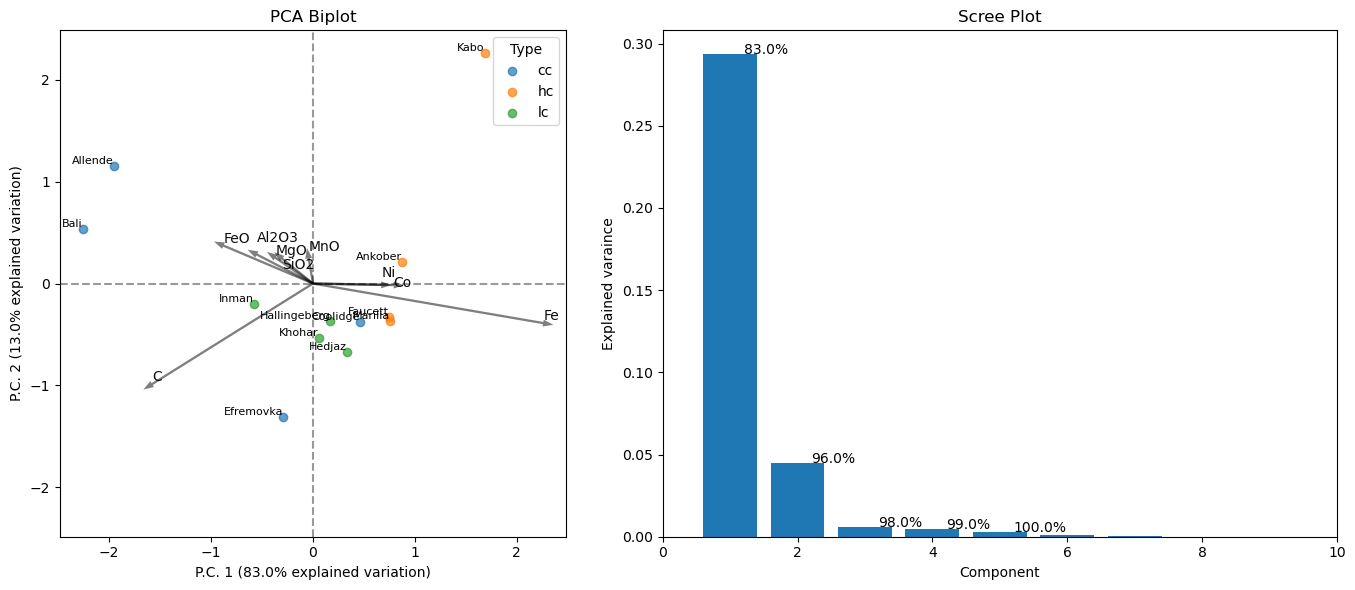

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each Type class
unique_types = data['Type'].unique()
color_map = {type_name: color for type_name, color in zip(unique_types, plt.cm.tab10.colors)}

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create the biplot object, telling it to use ax1
mypca = coda.pca.Biplot(data.iloc[:, 2:], axis=ax1, default=False)

# Plot on ax1 (we'll skip the default plotscores to control colors ourselves)
mypca.plotloadings()
mypca.adjustloadinglabels()
ax1.set_title('PCA Biplot')

# Plot points colored by Type
for type_name in unique_types:
    indices = data[data['Type'] == type_name].index
    samples = mypca.scores.columns[indices]
    x = [mypca.scores.loc['pc1', s] for s in samples]
    y = [mypca.scores.loc['pc2', s] for s in samples]
    ax1.scatter(x, y, color=color_map[type_name], label=type_name, alpha=0.7)

    # Annotate each point with location
    for i, s in zip(indices, samples):
        location_label = data.loc[i, 'Location']
        ax1.text(mypca.scores.loc['pc1', s], mypca.scores.loc['pc2', s],
                 str(location_label), fontsize=8, ha='right', va='bottom')

# Add legend
ax1.legend(title='Type')

# Run SVD and plot scree plot on ax2
scores, eig_val, loadings = coda.pca._svd(
    data.iloc[:, 2:].coda.center().coda.scale().coda.clr()
)
coda.pca.scree_plot(ax2, eig_val)
ax2.set_title('Scree Plot')

plt.tight_layout()
#plt.savefig('../handin/figures/pca_biplot.png', dpi=300, bbox_inches='tight')
plt.show()

#### 2.2 Subcompositional analysis

##### MgO, SiO2 vs C

In [8]:

MgO_SiO2_Carbon = data[['MgO', 'SiO2', 'C']]

#Apply closure to 100
MgO_SiO2_Carbon = MgO_SiO2_Carbon.coda.closure(100)

#Center the data
MgO_SiO2_Carbon = MgO_SiO2_Carbon.coda.center()

#Clr transform
MgO_SiO2_Carbon = MgO_SiO2_Carbon.coda.clr()


# Run svd 
scores, eig_val, loadings = coda.pca._svd(MgO_SiO2_Carbon)
explained_var = eig_val/sum(eig_val)

loadings['lamda'] = eig_val[:2]
loadings['expl_var'] = explained_var[:2]


PC1 = loadings.iloc
# Save the loadings
loadings

,MgO,SiO2,C,lamda,expl_var
pc1,1.164362,1.250791,-2.415154,2.958578,0.949487
pc2,0.112601,-0.109947,-0.002655,0.157399,0.050513


/home/aws/miniconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/miniconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/miniconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


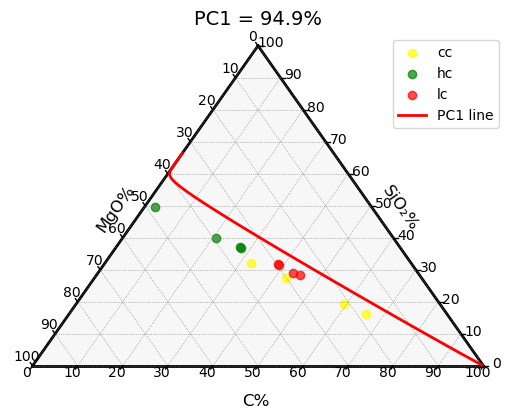

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

# Prepare data
MgO_SiO2_Carbon = data[['MgO', 'SiO2', 'C']].coda.closure(100)
gm = MgO_SiO2_Carbon.coda.gmean()
e_PC1 = loadings.iloc[0, 0:3]

# Center the data
centered_data = (MgO_SiO2_Carbon / gm).coda.closure(100)

# Sweep alpha range for PC1 line
alpha_range = np.linspace(-3, 3, 100)
compositional_line = []
for alpha in alpha_range:
    perturbed = np.exp(alpha * e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100
    compositional_line.append(closed)
compositional_line = np.array(compositional_line)

# Explained variance
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Group colors (yellow, green, red)
custom_colors = ['yellow', 'green', 'red']
types = data['Type'].unique()
if len(types) > 3:
    raise ValueError("More than 3 types found — only prepared 3 colors!")

# Build ternary plot
scale = 100
figure, tax = ternary.figure(scale=scale)
tax.set_title(f"PC1 = {pc1_var:.1f}%", fontsize=14)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=10, color="gray", linewidth=0.5)
tax.ticks(axis='lbr', multiple=10, linewidth=1)

# Correct axis labels (matching plotting order: C, SiO₂, MgO)
tax.left_axis_label("MgO%", fontsize=12)
tax.right_axis_label("SiO₂%", fontsize=12)
tax.bottom_axis_label("C%", fontsize=12)

# Plot each group (centered data, reordered to [C, SiO2, MgO])
for i, group in enumerate(types):
    idx = data['Type'] == group
    points = centered_data.loc[idx, ['C', 'SiO2', 'MgO']].values
    tax.scatter(points, marker='o', color=custom_colors[i], label=group, alpha=0.7)

# Plot PC1 line (reordered for ternary: C, SiO2, MgO)
line_points = compositional_line[:, [2, 1, 0]].tolist()
tax.plot(line_points, color='red', linewidth=2, label='PC1 line')

# Add legend
tax.legend()

# Remove outer frame
tax.get_axes().axis('off')

# Hide matplotlib ticks
tax.clear_matplotlib_ticks()

# Show plot
#tax.savefig('../handin/figures/ternary_plot.png', dpi=300, bbox_inches='tight')
tax.show()


##### Old MgO, SiO2 plot
In thisa onea i only used the plot.ternary package.

/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


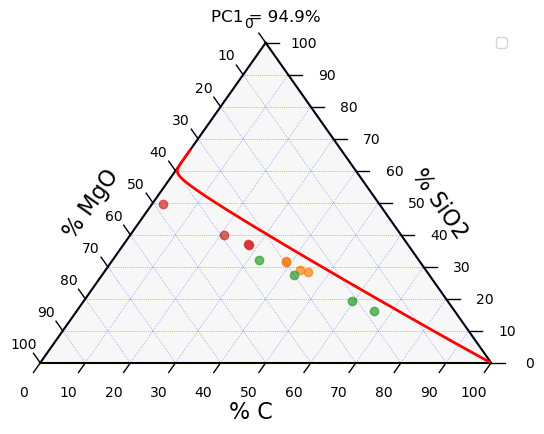

In [ ]:
# Select subcomposition
MgO_SiO2_Carbon = data[['MgO', 'SiO2', 'C']]
MgO_SiO2_Carbon = MgO_SiO2_Carbon.coda.closure(100)

# Get geometric mean (in original space)
gm = MgO_SiO2_Carbon.coda.gmean()

# Get PC1 eigenvector (direction)
e_PC1 = loadings.iloc[0, 0:3]

# Sweep a range of alpha values
alpha_range = np.linspace(-3, 3, 100)
compositional_line = []

for alpha in alpha_range:
    perturbed = np.exp(alpha * e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100  # close to 100%
    compositional_line.append(closed)

compositional_line = np.array(compositional_line)

# Compute explained variance percentages
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Get the ternary plot object
tax = plot.ternary(MgO_SiO2_Carbon, center=True, descr=data['Type'])



# Plot the compositional line (note: reorder to [C, SiO2, MgO])
line_points = compositional_line[:, [2, 1, 0]].tolist()
tax.plot(line_points, color='red', linewidth=2)

# Add explained variance as plot title
tax.get_axes().set_title(f"PC1 = {pc1_var:.1f}%", fontsize=12)

# Add legend for the types
tax.legend()

# Show plot
tax.show()

##### Ni Co vs C

In [ ]:

Ni_Co_Carbon = data[['Ni', 'Co', 'MnO']]

#Apply closure to 100
Ni_Co_Carbon = Ni_Co_Carbon.coda.closure(100)

#Center the data
Ni_Co_Carbon = Ni_Co_Carbon.coda.center()

#Clr transform
Ni_Co_Carbon = Ni_Co_Carbon.coda.clr()
# Run svd 
scores, eig_val, loadings = coda.pca._svd(Ni_Co_Carbon)
explained_var = eig_val/sum(eig_val)

loadings['lamda'] = eig_val[:2]
loadings['expl_var'] = explained_var[:2]


PC1 = loadings.iloc
loadings

,Ni,Co,MnO,lamda,expl_var
pc1,0.403616,0.841469,-1.245085,1.556025,0.733884
pc2,-0.436830,0.345164,0.091667,0.564235,0.266116


/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


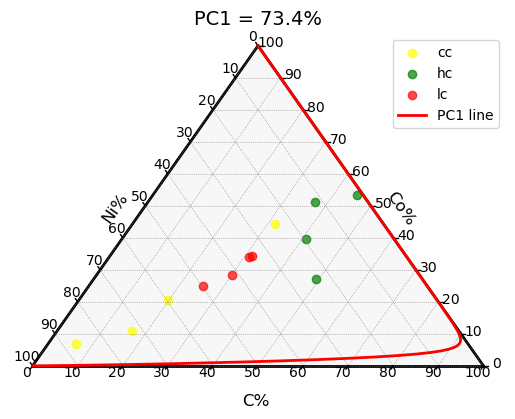

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

# Prepare data
Ni_Co_Carbon = data[['Ni', 'Co', 'C']].coda.closure(100)
gm = Ni_Co_Carbon.coda.gmean()
e_PC1 = loadings.iloc[0, 0:3]

# Center the data
centered_data = (Ni_Co_Carbon / gm).coda.closure(100)

# Sweep alpha range for PC1 line
alpha_range = np.linspace(-100, 100, 1000)
compositional_line = []
for alpha in alpha_range:
    perturbed = np.exp(alpha * e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100
    compositional_line.append(closed)
compositional_line = np.array(compositional_line)

# Explained variance
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Group colors (yellow, green, red)
custom_colors = ['yellow', 'green', 'red']
types = data['Type'].unique()
if len(types) > 3:
    raise ValueError("More than 3 types found — only prepared 3 colors!")

# Build ternary plot
scale = 100
figure, tax = ternary.figure(scale=scale)
tax.set_title(f"PC1 = {pc1_var:.1f}%", fontsize=14)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=10, color="gray", linewidth=0.5)
tax.ticks(axis='lbr', multiple=10, linewidth=1)

# Correct axis labels (matching plotting order: C, Co, Ni)
tax.left_axis_label("Ni%", fontsize=12)
tax.right_axis_label("Co%", fontsize=12)
tax.bottom_axis_label("C%", fontsize=12)

# Plot each group (centered data, reordered to [C, Co, Ni])
for i, group in enumerate(types):
    idx = data['Type'] == group
    points = centered_data.loc[idx, ['Ni', 'Co', 'C']].values
    tax.scatter(points, marker='o', color=custom_colors[i], label=group, alpha=0.7)

# Plot PC1 line (reordered for ternary: C, Co, Ni)
line_points = compositional_line[:, [0, 1, 2]].tolist()
tax.plot(line_points, color='red', linewidth=2, label='PC1 line')

# Add legend
tax.legend()

# Remove outer frame
tax.get_axes().axis('off')

# Hide matplotlib ticks
tax.clear_matplotlib_ticks()

# Show plot
tax.show()


/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


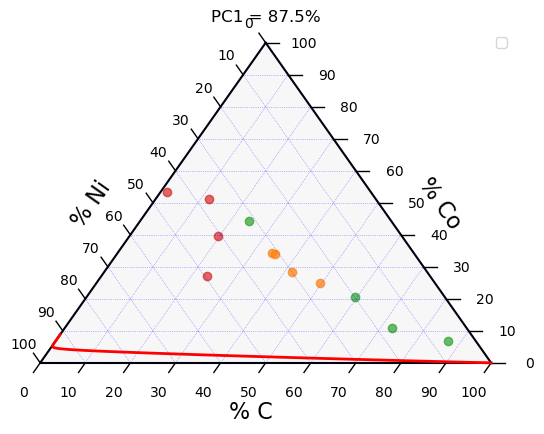

In [ ]:
# Select subcomposition
MgO_SiO2_Carbon = data[['Ni', 'Co', 'C']]
MgO_SiO2_Carbon = MgO_SiO2_Carbon.coda.closure(100)

# Get geometric mean (in original space)
gm = MgO_SiO2_Carbon.coda.gmean()

# Get PC1 eigenvector (direction)
e_PC1 = loadings.iloc[0, 0:3]

# Sweep a range of alpha values
alpha_range = np.linspace(-3, 3, 100)
compositional_line = []

for alpha in alpha_range:
    perturbed = np.exp(alpha * e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100  # close to 100%
    compositional_line.append(closed)

compositional_line = np.array(compositional_line)

# Compute explained variance percentages
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Get the ternary plot object
tax = plot.ternary(MgO_SiO2_Carbon, center=True, descr=data['Type'])



# Plot the compositional line (note: reorder to [C, SiO2, MgO])
line_points = compositional_line[:, [2, 1, 0]].tolist()
tax.plot(line_points, color='red', linewidth=2)

# Add explained variance as plot title
tax.get_axes().set_title(f"PC1 = {pc1_var:.1f}%", fontsize=12)

# Add legend for the types
tax.legend()

# Show plot
tax.show()

##### FeO Al2O3 C

In [ ]:

Fe_Al2O3_C = data[['FeO', 'Al2O3', 'C']]

#Apply closure to 100
Fe_Al2O3_C = Ni_Co_Carbon.coda.closure(100)

#Center the data
Fe_Al2O3_C = Ni_Co_Carbon.coda.center()

#Clr transform
Fe_Al2O3_C = Ni_Co_Carbon.coda.clr()
# Run svd 
scores, eig_val, loadings = coda.pca._svd(Fe_Al2O3_C)
explained_var = eig_val/sum(eig_val)

loadings['lamda'] = eig_val[:2]
loadings['expl_var'] = explained_var[:2]


PC1 = loadings.iloc
loadings

,Ni,Co,C,lamda,expl_var
pc1,-5.609459,5.380840,0.228619,7.776358,0.647191
pc2,-1.621590,-1.837454,3.459044,4.239195,0.352809


/home/aws/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


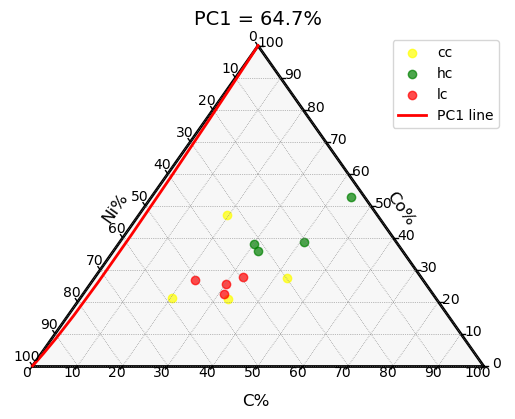

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

# Prepare data
FeO_Al2O3_C = data[['FeO', 'Al2O3', 'C']].coda.closure(100)
gm = FeO_Al2O3_C.coda.gmean()
e_PC1 = loadings.iloc[0, 0:3]

# Center the data
centered_data = (FeO_Al2O3_C / gm).coda.closure(100)

# Sweep alpha range for PC1 line
alpha_range = np.linspace(-3, 3, 100)
compositional_line = []
for alpha in alpha_range:
    perturbed = np.exp(alpha ** e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100
    compositional_line.append(closed)
compositional_line = np.array(compositional_line)

# Explained variance
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Group colors (yellow, green, red)
custom_colors = ['yellow', 'green', 'red']
types = data['Type'].unique()
if len(types) > 3:
    raise ValueError("More than 3 types found — only prepared 3 colors!")

# Build ternary plot
scale = 100
figure, tax = ternary.figure(scale=scale)
tax.set_title(f"PC1 = {pc1_var:.1f}%", fontsize=14)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=10, color="gray", linewidth=0.5)
tax.ticks(axis='lbr', multiple=10, linewidth=1)

# Correct axis labels (matching plotting order: C, Co, Ni)
tax.left_axis_label("Ni%", fontsize=12)
tax.right_axis_label("Co%", fontsize=12)
tax.bottom_axis_label("C%", fontsize=12)

# Plot each group (centered data, reordered to [C, Co, Ni])
for i, group in enumerate(types):
    idx = data['Type'] == group
    points = centered_data.loc[idx, ['FeO', 'Al2O3', 'C']].values
    tax.scatter(points, marker='o', color=custom_colors[i], label=group, alpha=0.7)

# Plot PC1 line (reordered for ternary: C, Co, Ni)
line_points = compositional_line[:, [2, 1, 0]].tolist()
tax.plot(line_points, color='red', linewidth=2, label='PC1 line')

# Add legend
tax.legend()

# Remove outer frame
tax.get_axes().axis('off')

# Hide matplotlib ticks
tax.clear_matplotlib_ticks()

# Show plot
tax.show()


/home/aws/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/home/aws/anaconda3/lib/python3.12/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

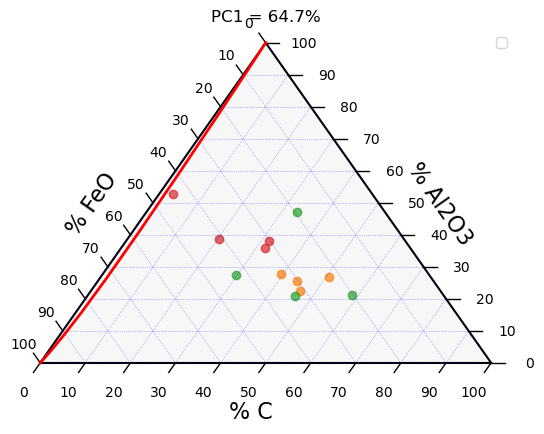

In [ ]:
# Select subcomposition
FeO_Al2O3_C = data[['FeO', 'Al2O3', 'C']]
FeO_Al2O3_C = FeO_Al2O3_C.coda.closure(100)

# Get geometric mean (in original space)
gm = FeO_Al2O3_C.coda.gmean()

# Get PC1 eigenvector (direction)
e_PC1 = loadings.iloc[0, 0:3]

# Sweep a range of alpha values
alpha_range = np.linspace(-3, 3, 100)
compositional_line = []

for alpha in alpha_range:
    perturbed = np.exp(alpha ** e_PC1) * gm
    closed = perturbed / np.sum(perturbed) * 100  # close to 100%
    compositional_line.append(closed)

compositional_line = np.array(compositional_line)

# Compute explained variance percentages
explained_var = eig_val / np.sum(eig_val)
pc1_var = explained_var[0] * 100
pc2_var = explained_var[1] * 100

# Get the ternary plot object
tax = plot.ternary(FeO_Al2O3_C, center=True, descr=data['Type'])



# Plot the compositional line (note: reorder to [C, SiO2, MgO])
line_points = compositional_line[:, [2, 1, 0]].tolist()
tax.plot(line_points, color='red', linewidth=2)

# Add explained variance as plot title
tax.get_axes().set_title(f"PC1 = {pc1_var:.1f}%", fontsize=12)

# Add legend for the types
tax.legend()

# Show plot
tax.show()